In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import os
import random

from rdkit.Chem import MolFromSmiles

from utils.utils import *
from utils.dataset import *
from models.MixedNN import Encoder, Decoder, Predictor

%load_ext autoreload
%autoreload 2

In [2]:
DATADIR = './data/gdb13-augmented/'
RUNDIR = './runs/train16-64/'
LOGFILE = os.path.join(RUNDIR, 'log.csv')
DATASPEC_FILE = os.path.join(DATADIR, 'spec.json')
RUNSPEC_FILE = os.path.join(RUNDIR, 'spec.json')

dataspec = fetch_params(DATASPEC_FILE)
runspec = fetch_params(RUNSPEC_FILE)

to_indices, from_distribution = make_embed_utils(dataspec)

## Data

In [3]:
trainset, testset = make_data(DATADIR, to_indices, n=1000)

## Model

In [4]:
kwargs = {
    'L': runspec.L, 
    'alphabet_len': len(dataspec.alphabet), 
    'smile_len': dataspec.smile_len
}

encoder = Encoder(**kwargs)
encoder.load_state_dict(torch.load(RUNDIR + 'encoder_weights.pth', map_location=torch.device('cpu')))
encoder.eval()

predictor = Predictor(**kwargs)
predictor.load_state_dict(torch.load(RUNDIR + 'predictor_weights.pth', map_location=torch.device('cpu')))
predictor.eval()

decoder = Decoder(**kwargs)
decoder.load_state_dict(torch.load(RUNDIR + 'decoder_weights.pth', map_location=torch.device('cpu')))
decoder.eval()

print(f'Encoder: {sum(p.numel() for p in encoder.parameters())} parameters')
print(f'Predictor: {sum(p.numel() for p in predictor.parameters())} parameters')
print(f'Decoder: {sum(p.numel() for p in decoder.parameters())} parameters')

Encoder: 1990680 parameters
Predictor: 7427 parameters
Decoder: 229408 parameters


In [9]:
encoder

Encoder(
  (embed): Embedding(32, 8)
  (cnn): Sequential(
    (0): Conv1d(8, 8, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=(3,))
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv1d(8, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (rnn): GRU(8, 384, num_layers=2, batch_first=True, dropout=0.2)
  (dense): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=768, out_features=768, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=768, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
  )
  (z_mean): Linear(in_features=64, out_features=64, bias=True)
  (z_logvar): Linear(in_features=64, out_features=64, bias=True)
)

In [11]:
decoder

Decoder(
  (dense): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (decode_next): DecodeNext(
    (embed): Embedding(32, 8)
    (rnn): GRU(8, 256, batch_first=True)
    (dense): Linear(in_features=256, out_features=32, bias=True)
  )
)

OC1CCC23CC4CC2CC((C3)[NH2+]4
OC1CCC23CC4CC2C1C(C3)[NH2+]4


[10:36:54] SMILES Parse Error: syntax error while parsing: OC1CCC23CC4CC2CC((C3)[NH2+]4
[10:36:54] SMILES Parse Error: Failed parsing SMILES 'OC1CCC23CC4CC2CC((C3)[NH2+]4' for input: 'OC1CCC23CC4CC2CC((C3)[NH2+]4'


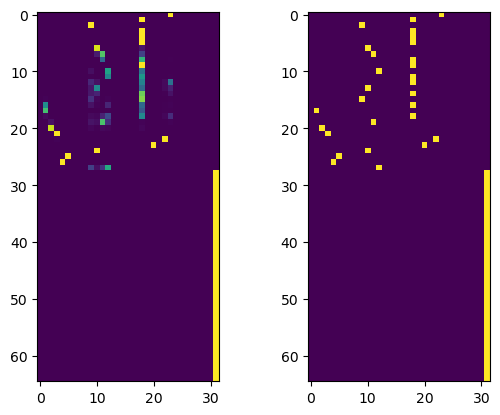

In [8]:
x, *_ = testset.sample(1)
z, *_ = encoder(x)
x_hat = decoder(z)

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(x_hat.softmax(dim=-1).squeeze().detach())

x_dist = torch.zeros(size=x_hat.shape)
x_dist[torch.arange(x_dist.size(0)), torch.arange(x_dist.size(1)), x] = 1
ax1.imshow(x_dist.squeeze().detach(), vmin=0, vmax=1)

print(from_distribution(x_hat)[0])
print(from_distribution(x_dist)[0])
MolFromSmiles(from_distribution(x_hat)[0])

Text(0.5, 0, 'epoch')

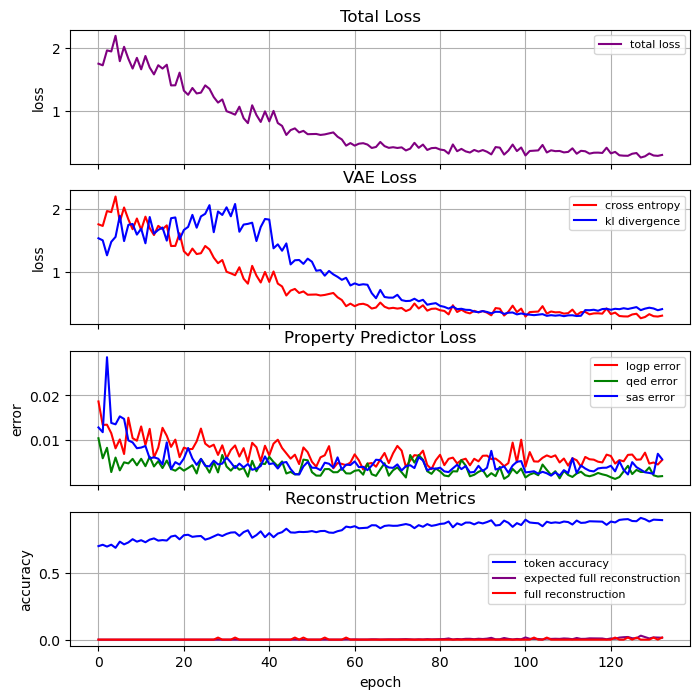

In [6]:
log = pd.read_csv(LOGFILE)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, sharex=True, figsize=(8, 8))

ax0.set_ylabel('loss')
ax0.set_title('Total Loss')
ax0.plot(log['loss'], color='purple', label='total loss')
ax0.grid()
ax0.legend(prop={'size': 8})

ax1.set_ylabel('loss')
ax1.set_title('VAE Loss')
ax1.plot(log['ce'], color='red', label='cross entropy')
ax1.plot(log['kl'] * 0.1, color='blue', label='kl divergence')
ax1.grid()
ax1.legend(prop={'size': 8})

ax2.set_ylabel('error')
ax2.set_title('Property Predictor Loss')
ax2.plot(log['logp']/100, color='red', label='logp error')
ax2.plot(log['qed'], color='green', label='qed error')
ax2.plot(log['sas']/100, color='blue', label='sas error')
ax2.grid()
ax2.legend(prop={'size': 8})

ax3.set_ylabel('accuracy')
ax3.set_title('Reconstruction Metrics')
ax3.plot(log['accuracy'], color='blue', label='token accuracy')
ax3.plot(log['accuracy'] ** 40, color='purple', label='expected full reconstruction')
ax3.plot(log['prec'], color='red', label='full reconstruction')
ax3.grid()
ax3.legend(prop={'size': 8})
ax3.set_xlabel('epoch')